In [3]:
import pandas as pd
import numpy as np
import rebound
import reboundx
import matplotlib.pyplot as plt
from multiprocessing import Pool
from matplotlib.lines import Line2D

In [44]:


# Constantes de conversión
M_Sun    = 1.98847e30  # Masa del Sol en kg
M_Jup    = 1.89813e27  # Masa de Júpiter en kg
R_Jup    = 7.1492e7  # Radio de Júpiter en metros
AU_in_m  = 1.495978707e11  # Unidades Astronómicas en metros
R_Io_km  = 1821.6  # Radio de Io en km
R_Io_m   = R_Io_km * 1000  # Radio de Io en metros
M_Io_kg  = 8.9319e22  # Masa de Io en kg

# Cargar el archivo con los parámetros relevantes
file_path   = './data_wasp49Ab.csv'  # Ruta del archivo proporcionado
wasp49_data = pd.read_csv(file_path)

# Extraer los parámetros relevantes del archivo proporcionado
mass_planet   = wasp49_data['mass'].iloc[0]  # Masa del planeta en M_Jup
radius_planet = wasp49_data['radius'].iloc[0]  # Radio del planeta en R_Jup
a_planet      = wasp49_data['semi_major_axis'].iloc[0]  # Semieje mayor en AU
e_planet      = 0.03#wasp49_data['eccentricity'].iloc[0]  # Excentricidad
mass_star     = wasp49_data['star_mass'].iloc[0]  # Masa de la estrella en M_Sun

# Convertir masas a M_Sun
mass_planet_sun = mass_planet * 0.000954588  # Masa del planeta en M_Sun
mass_star_sun   = mass_star  # Masa de la estrella en M_Sun

# Convertir radios a AU
radius_planet_au = radius_planet * R_Jup / AU_in_m  # Radio del planeta en AU

# Funciones para calcular parámetros relevantes
def calcular_limite_roche(mass_planet, mass_moon, radius_moon):
    """
    Calcula el límite de Roche para una luna orbitando un planeta,
    considerando las masas y el radio de la luna.
    """
    limite_roche = 2.44 * (mass_planet / mass_moon) ** (1/3) * radius_moon
    return limite_roche

def calcular_radio_hill(mass_planet, mass_star, a_planet):
    """
    Calcula el radio de Hill para un planeta orbitando una estrella.
    """
    radio_hill = a_planet * (mass_planet / (3 * mass_star)) ** (1/3)
    return radio_hill

# Relación masa-radio para lunas rocosas (exponente ajustado)
def calcular_radio_moon(mass_moon_kg):
    return R_Io_m * (mass_moon_kg / M_Io_kg) ** (1/3.5)  # Ajustar el exponente para mejorar la precisión

# Configuración inicial y cálculo de J2
P_rot_s         = 2.8 * 24 * 60 * 60  # Período de rotación en segundos
mass_planet_kg  = mass_planet * M_Jup  # Masa del planeta en kg
radius_planet_m = radius_planet * R_Jup  # Radio del planeta en metros

# Calcular J2
def calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s):
    Omega = 2 * np.pi / P_rot_s  # Velocidad angular en rad/s
    G     = 6.67430e-11  # Constante gravitacional en m^3 kg^-1 s^-2
    J2    = (1/2) * (3/2) * ((Omega**2) * (radius_planet_m**3)) / (G * mass_planet_kg)
    return J2

J2_value = calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s)
print(f"El valor de J2 para el planeta es: {J2_value}")

# Calcular el radio de Hill una sola vez
radio_hill = calcular_radio_hill(mass_planet_sun, mass_star_sun, a_planet)

# Crear la lista de parámetros para todas las combinaciones de a y m
#####################################################################
Ngrid = 40
t_end = 1e3
dt    = 1e-5
par_a = np.linspace(1 * radius_planet_au, 0.5 * radio_hill, Ngrid)
#par_m = np.linspace(0.001* M_Io_kg, 2 * M_Io_kg, Ngrid)
#par_m = np.logspace(20, 23, Ngrid)
par_m = np.logspace(21.5, 23.67, Ngrid)
par_e = 0.0
par_i_values = np.deg2rad([0, 10, 20, 30, 39])  # Inclinaciones en radianes

# Precalcular el radio de la luna y el límite de Roche para cada combinación de parámetros
precalculated_params = []
for mass_moon_kg in par_m:
    radius_moon_m = calcular_radio_moon(mass_moon_kg)
    radius_moon_au = radius_moon_m / AU_in_m  # Radio de la luna en AU
    for a in par_a:
        limite_roche = calcular_limite_roche(mass_planet_sun, mass_moon_kg / M_Sun, radius_moon_au)
        precalculated_params.append((a, mass_moon_kg, radius_moon_au, limite_roche))
#####################################################################

# Función para calcular si una luna es expulsada con efectos de J2 y GR
def simulation_ejection_with_J2_GR(par):
    """
    Ejecuta una simulación de Rebound y verifica si la luna es expulsada del sistema,
    teniendo en cuenta el efecto J2 del planeta y las correcciones relativistas.

    Parameters:
    - par (tuple): Tupla que contiene (a_moon, mass_moon, radius_moon, limite_roche, par_i)

    Returns:
    - int: 0 si la luna es expulsada, 1 si la luna permanece en órbita
    """
    a, mass_moon_kg, radius_moon_au, limite_roche, par_i = par
    mass_moon_sun = mass_moon_kg / M_Sun  # Masa de la luna en M_Sun
    
    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.integrator = "whfast"
    sim.dt = dt

    # Añadir la estrella
    sim.add(m=mass_star_sun, hash="star")  # Estrella central

    # Añadir el planeta orbitando la estrella
    sim.add(m=mass_planet_sun, a=a_planet, e=e_planet, r=radius_planet_au, hash="planet")

    # Añadir la luna orbitando el planeta
    sim.add(primary=sim.particles[1], m=mass_moon_sun, a=a, e=par_e, inc=par_i, hash="moon")

    # Adding relativistic effects y J2 usando REBOUNDx
    rebx = reboundx.Extras(sim)
    gr = rebx.load_force("gr_potential")
    rebx.add_force(gr)
    gr.params["c"] = 63241.077  # Velocidad de la luz en AU/yr

    # Adding planet oblateness (J2)
    gh = rebx.load_force("gravitational_harmonics")
    rebx.add_force(gh)
    planet = sim.particles["planet"]
    planet.params["J2"] = J2_value
    planet.params["R_eq"] = radius_planet_au

    sim.move_to_com()

    try:
        while sim.t < t_end * 2 * np.pi:
            sim.integrate(sim.t + 1e-2, exact_finish_time=0)
            # Verificar si la excentricidad de la luna supera 1 (es expulsada) o si el periapsis es menor que el radio del planeta
            moon_orbit = sim.particles["moon"].orbit(primary=sim.particles["planet"])
            periapsis = moon_orbit.a * (1 - moon_orbit.e)  # Cálculo del periapsis
            if moon_orbit.e >= 1.0 or moon_orbit.a < limite_roche or moon_orbit.a > radio_hill or periapsis <= radius_planet_au:
                return 0  # La luna es expulsada
        return 1  # La luna permanece en órbita
    except rebound.Escape:
        return 0  # La luna es expulsada

# Inicializar la matriz que contendrá la suma de todos los resultados
ejection_matrix_sum = np.zeros((len(par_m), len(par_a)), dtype=int)

# Ejecutar las simulaciones en paralelo para cada inclinación
for idx, par_i in enumerate(par_i_values):
    # Actualizar los parámetros precalculados con el valor actual de inclinación
    params_with_inclination = [(a, m, r, lr, par_i) for (a, m, r, lr) in precalculated_params]

    ejection_results = []
    with Pool() as pool:
        ejection_results = pool.map(simulation_ejection_with_J2_GR, params_with_inclination)

    # Convertir los resultados en una matriz
    ejection_matrix = np.array(ejection_results, dtype=int).reshape((len(par_m), len(par_a)))

    # Acumular los resultados en la matriz de suma
    ejection_matrix_sum += ejection_matrix
    print(np.rad2deg(par_i),'°')
    print(ejection_matrix)
    # Definir la ruta y nombre del archivo para guardar los datos, incluyendo la inclinación
    save_path = f'./data/ejection_J2_GR_map_a_m_t{t_end:.0f}_i{np.rad2deg(par_i):.0f}_lm.npz'

    # Guardar par_a, par_m y ejection_matrix en un archivo comprimido .npz
    np.savez_compressed(save_path, par_a=par_a, par_m=par_m, ejection_matrix=ejection_matrix)

    print(f'Datos guardados exitosamente en {save_path}')

# Guardar la matriz completa de resultados acumulados
full_save_path = './data/ejection_J2_GR_sum_results_lm.npz'
np.savez_compressed(full_save_path, par_a=par_a, par_m=par_m, ejection_matrix_sum=ejection_matrix_sum)
print(f'Matriz completa de resultados acumulados guardada exitosamente en {full_save_path}')

# Visualizar los resultados de expulsión
A, M = np.meshgrid(par_a, par_m)


El valor de J2 para el planeta es: 0.006288045478463178
0.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_m_t1000_i0_lm.npz
10.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_m_t1000_i10_lm.npz
20.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_m_t1000_i20_lm.npz
29.999999999999996 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
Datos guardados exitosamente en ./data/ejection_J2_GR_map_a_m_t1000_i30_lm.npz
39.0 °
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 

Text(0.5, 1.0, 'Límite de Roche: t$_{end}$ = 1000 yr')

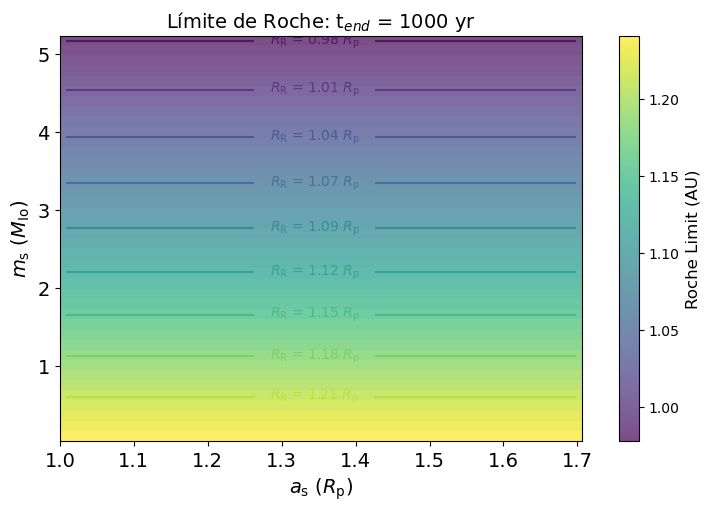

In [45]:
# Crear el gráfico del límite de Roche vs a/Rp y masa
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = plt.subplot(111)

# Definir el extent del gráfico en términos de a/Rp y m
extent = [min(par_a/radius_planet_au), max(par_a/radius_planet_au), min(par_m/M_Io_kg), max(par_m/M_Io_kg)]
ax.set_xlim(extent[0], extent[1])
ax.set_xlabel(r"$a_\mathrm{s}$ ($R_\mathrm{p}$)", fontsize=14)
ax.set_ylim(extent[2], extent[3])
ax.set_ylabel(r"$m_\mathrm{s}$ ($M_\mathrm{Io}$)", fontsize=14)

# Aumentar el tamaño de los ticks en los ejes X e Y
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Crear la matriz del límite de Roche
roche_matrix = np.array([par[3] for par in precalculated_params]).reshape((len(par_m), len(par_a)))

# Graficar el límite de Roche
im = ax.imshow(roche_matrix/radius_planet_au, interpolation="none", cmap="viridis",
               origin="lower", aspect='auto', extent=extent, alpha=0.7)
#im=ax.contour(roche_matrix/radius_planet_au,  levels=levels, cmap="viridis",
               #origin="lower", extent=extent, alpha=0.7)

cbr = plt.colorbar(im, ax=ax)
cbr.set_label("Roche Limit (AU)", fontsize=12)


levels = np.linspace(cbr.vmin,cbr.vmax,10)

# Graficar el límite de Roche con contornos y etiquetar los niveles
contour = ax.contour(roche_matrix/radius_planet_au, levels=levels, cmap="viridis",
                     origin="lower", extent=extent, alpha=0.7)
ax.clabel(contour, inline=True, fontsize=10, fmt=r'$R_\mathrm{R}$ = %.2f $R_\mathrm{p}$')

# Configurar el título con LaTeX
ax.set_title(fr'Límite de Roche: t$_{{end}}$ = {t_end:g} yr', fontsize=14)



Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_m_i0.6806784082777885_t1000.0_N40_e003.png


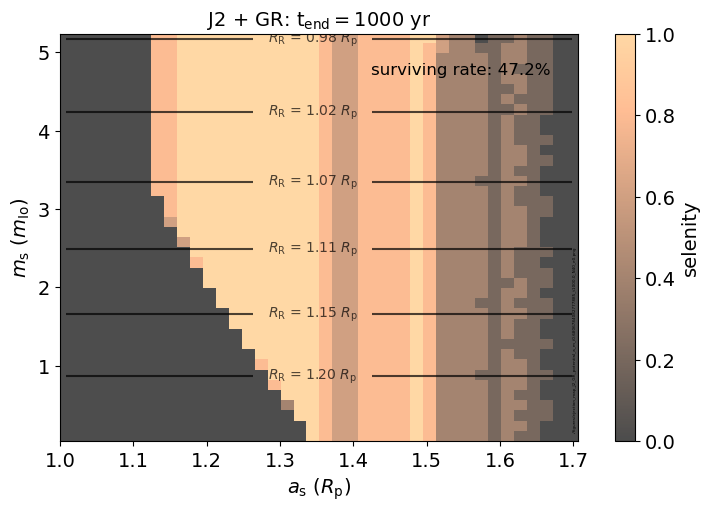

In [48]:

# Crear el gráfico de expulsión vs a/Rp y masa
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = plt.subplot(111)

# Definir el extent del gráfico en términos de a/Rp y m
extent = [min(par_a/radius_planet_au), max(par_a/radius_planet_au), min(par_m/M_Io_kg), max(par_m/M_Io_kg)]
ax.set_xlim(extent[0], extent[1])
ax.set_xlabel(r"$a_\mathrm{s}$ ($R_\mathrm{p}$)", fontsize=14)
ax.set_ylim(extent[2], extent[3])
ax.set_ylabel(r"$m_\mathrm{s}$ ($m_\mathrm{Io}$)", fontsize=14)

# Aumentar el tamaño de los ticks en los ejes X e Y
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Graficar la imagen de expulsión
im = ax.imshow(ejection_matrix_sum / len(par_i_values), interpolation="none", cmap="copper",
               origin="lower", aspect='auto', extent=extent, alpha=0.7)
cb = plt.colorbar(im, ax=ax)
cb.set_label("selenity", fontsize=14)
cb.ax.tick_params(labelsize=14)

levels = np.linspace(cbr.vmin,cbr.vmax,7)
contour = ax.contour(roche_matrix/radius_planet_au, levels=levels, colors='k',
                     origin="lower", extent=extent, alpha=0.7)
ax.clabel(contour, inline=True,   fontsize=10, fmt=r'$R_\mathrm{R}$ = %.2f $R_\mathrm{p}$')

ax.text(0.6,0.9,f'surviving rate: {(ejection_matrix_sum.sum() / (len(par_i_values)*len(ejection_matrix_sum)**2)) * 100:.1f}%', fontsize=12,transform=ax.transAxes)

# Configurar el título con LaTeX
#ax.set_title(rf'J2 + GR: $i_s$ = {par_i}°, \mathrm{{t}}_{{end}} = {t_end:g}$ yr', fontsize=14)
ax.set_title(rf'J2 + GR: $\mathrm{{t}}_{{\mathrm{{end}}}} = {t_end:g}$ yr', fontsize=14)

ax.text(0.993,0.25,f'./figures/ejection_map_J2_GR_potential_a_m_i{par_i}_t{t_end}_N{Ngrid}_e0.png', fontsize=3, rotation =90, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Guardar el gráfico
plt.savefig(f'./figures/plooneticity_J2_GR_potential_a_m_i_full_t{t_end}_N{Ngrid}_e0_lm.png', facecolor='w', dpi=300)
print(f'Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_m_i{par_i}_t{t_end}_N{Ngrid}_e003.png')


Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_m_i0.6806784082777885_t1000.0_N40_e003.png


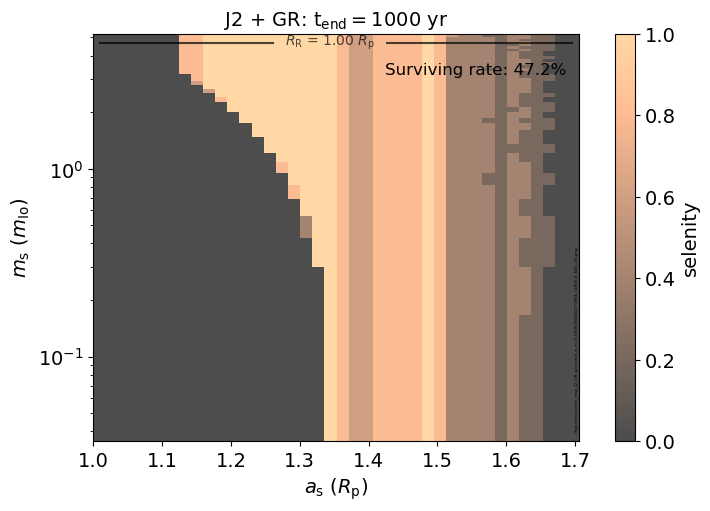

In [47]:
# Crear el gráfico de expulsión vs a/Rp y masa
fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = plt.subplot(111)

# Definir el extent del gráfico en términos de a/Rp y m
extent = [min(par_a/radius_planet_au), max(par_a/radius_planet_au), min(par_m/M_Io_kg), max(par_m/M_Io_kg)]
ax.set_xlim(extent[0], extent[1])
ax.set_xlabel(r"$a_\mathrm{s}$ ($R_\mathrm{p}$)", fontsize=14)
ax.set_yscale("log")  # Use logarithmic scale for mass
ax.set_ylabel(r"$m_\mathrm{s}$ ($m_\mathrm{Io}$)", fontsize=14)

# Aumentar el tamaño de los ticks en los ejes X e Y
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

# Graficar la imagen de expulsión
im = ax.imshow(ejection_matrix_sum / len(par_i_values), interpolation="none", cmap="copper",
               origin="lower", aspect='auto', extent=extent, alpha=0.7)
cb = plt.colorbar(im, ax=ax)
cb.set_label("selenity", fontsize=14)
cb.ax.tick_params(labelsize=14)

# Obtener límites de color
cmin, cmax = im.get_clim()
levels = np.linspace(cmin, cmax, 7)
contour = ax.contour(roche_matrix/radius_planet_au, levels=levels, colors='k',
                     origin="lower", extent=extent, alpha=0.7)
ax.clabel(contour, inline=True, fontsize=10, fmt=r'$R_\mathrm{R}$ = %.2f $R_\mathrm{p}$')

# Añadir anotación de la tasa de supervivencia
surviving_rate = (ejection_matrix_sum.sum() / (len(par_i_values) * len(ejection_matrix_sum) ** 2)) * 100
ax.text(0.6, 0.9, f'Surviving rate: {surviving_rate:.1f}%', fontsize=12, transform=ax.transAxes)

# Configurar el título con LaTeX
ax.set_title(rf'J2 + GR: $\mathrm{{t}}_{{\mathrm{{end}}}} = {t_end:g}$ yr', fontsize=14)

# Añadir texto con el nombre del archivo
ax.text(0.993, 0.25, f'./figures/ejection_map_J2_GR_potential_a_m_i{par_i}_t{t_end}_N{Ngrid}_e0.png',
        fontsize=3, rotation=90, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Guardar el gráfico
plt.savefig(f'./figures/plooneticity_J2_GR_potential_a_m_i_full_t{t_end}_N{Ngrid}_e0_lm.png', facecolor='w', dpi=300)
print(f'Gráfico guardado exitosamente como figures/ejection_map_J2_GR_potential_a_m_i{par_i}_t{t_end}_N{Ngrid}_e003.png')


In [41]:
ejection_matrix_sum.sum()

250

In [9]:

# Constantes de conversión
M_Sun = 1.98847e30  # Masa del Sol en kg
M_Jup = 1.89813e27  # Masa de Júpiter en kg
R_Jup = 7.1492e7  # Radio de Júpiter en metros
AU_in_m = 1.495978707e11  # Unidades Astronómicas en metros
R_Io_km = 1821.6  # Radio de Io en km
R_Io_m = R_Io_km * 1000  # Radio de Io en metros
M_Io_kg = 8.9319e22  # Masa de Io en kg

# Cargar el archivo con los parámetros relevantes
file_path = './data_wasp49Ab.csv'  # Ruta del archivo proporcionado
wasp49_data = pd.read_csv(file_path)

# Extraer los parámetros relevantes del archivo proporcionado
mass_planet   = wasp49_data['mass'].iloc[0]  # Masa del planeta en M_Jup
radius_planet = wasp49_data['radius'].iloc[0]  # Radio del planeta en R_Jup
a_planet      = wasp49_data['semi_major_axis'].iloc[0]  # Semieje mayor en AU
e_planet      = 0.03#wasp49_data['eccentricity'].iloc[0]  # Excentricidad
mass_star     = wasp49_data['star_mass'].iloc[0]  # Masa de la estrella en M_Sun

###########################################################
# Constantes físicas#
n_mass = 1 # Masa de la luna en múltiplos de Io
mass_moon_kg = n_mass * M_Io_kg  # Masa de la luna en kg

############################################################
# Relación masa-radio para lunas rocosas (exponente ajustado)
def calcular_radio_moon(mass_moon_kg):
    return R_Io_m * (mass_moon_kg / M_Io_kg) ** (1/3.5)  # Ajustar el exponente para mejorar la precisión

# Calcular el radio de la luna
radius_moon_m = calcular_radio_moon(mass_moon_kg)

# Convertir masas a M_Sun
mass_planet_sun = mass_planet * 0.000954588  # Masa del planeta en M_Sun
mass_star_sun = mass_star  # Masa de la estrella en M_Sun
mass_moon_sun = mass_moon_kg / M_Sun  # Masa de la luna en M_Sun

# Convertir radios a AU
radius_planet_au = radius_planet * R_Jup / AU_in_m  # Radio del planeta en AU
radius_moon_au = radius_moon_m / AU_in_m  # Radio de la luna en AU

# Funciones para calcular parámetros relevantes
def calcular_limite_roche(mass_planet, mass_moon, radius_moon):
    """
    Calcula el límite de Roche para una luna orbitando un planeta,
    considerando las masas y el radio de la luna.
    """
    limite_roche = 2.44 * (mass_planet / mass_moon) ** (1/3) * radius_moon
    return limite_roche

def calcular_radio_hill(mass_planet, mass_star, a_planet):
    """
    Calcula el radio de Hill para un planeta orbitando una estrella.
    """
    radio_hill = a_planet * (mass_planet / (3 * mass_star)) ** (1/3)
    return radio_hill

# Calcular límite de Roche y radio de Hill
limite_roche = calcular_limite_roche(mass_planet_sun, mass_moon_sun, radius_moon_au)
radio_hill = calcular_radio_hill(mass_planet_sun, mass_star_sun, a_planet)

# Imprimir resultados
print(f"Radio de la luna (m): {radius_moon_m}")
print(f"Radio de la luna (r_Io): {radius_moon_m/(1000*R_Io_km)}")
print(f"Masa de la luna (m_Io): {mass_moon_kg/M_Io_kg}")
print(f"Límite de Roche (AU): {limite_roche/radius_planet_au}")
print(f"Radio de Hill (AU): {radio_hill/radius_planet_au}")

# Configuración inicial y cálculo de J2
P_rot_s = 2.8 * 24 * 60 * 60  # Período de rotación en segundos
mass_planet_kg = mass_planet * M_Jup  # Masa del planeta en kg
radius_planet_m = radius_planet * R_Jup  # Radio del planeta en metros

# Calcular J2
def calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s):
    Omega = 2 * np.pi / P_rot_s  # Velocidad angular en rad/s
    G = 6.67430e-11  # Constante gravitacional en m^3 kg^-1 s^-2
    J2 = (1/2) * (3/2) * ((Omega**2) * (radius_planet_m**3)) / (G * mass_planet_kg)
    return J2

J2_value = calcular_J2(mass_planet_kg, radius_planet_m, P_rot_s)
print(f"El valor de J2 para el planeta es: {J2_value}")

# Crear la lista de parámetros para todas las combinaciones de a y e
#####################################################################
Ngrid = 30
t_end = 1e2
dt    = 1e-5
par_a = np.linspace(1 * limite_roche, 0.5 * radio_hill, Ngrid)
par_e = np.linspace(0., 0.5, Ngrid)



Radio de la luna (m): 1821600.0
Radio de la luna (r_Io): 1.0
Masa de la luna (m_Io): 1.0
Límite de Roche (AU): 1.0582377868649417
Radio de Hill (AU): 3.412576671604123
El valor de J2 para el planeta es: 0.006288045478463178


In [11]:
par_a/radius_planet_au

array([1.05823779, 1.08058436, 1.10293093, 1.1252775 , 1.14762407,
       1.16997064, 1.19231721, 1.21466378, 1.23701035, 1.25935692,
       1.28170349, 1.30405006, 1.32639663, 1.34874321, 1.37108978,
       1.39343635, 1.41578292, 1.43812949, 1.46047606, 1.48282263,
       1.5051692 , 1.52751577, 1.54986234, 1.57220891, 1.59455548,
       1.61690205, 1.63924862, 1.66159519, 1.68394177, 1.70628834])

In [8]:
limite_roche/radius_planet_au

0.971691589120846

In [14]:
mass_planet, radius_planet, a_planet

(0.399, 1.198, 0.03873)

In [36]:
par_m/M_Io_kg

array([1.11958262e-03, 1.38881977e-03, 1.72280306e-03, 2.13710263e-03,
       2.65103293e-03, 3.28855315e-03, 4.07938420e-03, 5.06039424e-03,
       6.27731752e-03, 7.78688642e-03, 9.65947636e-03, 1.19823866e-02,
       1.48639101e-02, 1.84383823e-02, 2.28724432e-02, 2.83728069e-02,
       3.51958976e-02, 4.36598047e-02, 5.41591117e-02, 6.71832913e-02,
       8.33395248e-02, 1.03381008e-01, 1.28242066e-01, 1.59081710e-01,
       1.97337669e-01, 2.44793419e-01, 3.03661324e-01, 3.76685779e-01,
       4.67271151e-01, 5.79640486e-01, 7.19032392e-01, 8.91945254e-01,
       1.10644019e+00, 1.37251685e+00, 1.70257962e+00, 2.11201585e+00,
       2.61991328e+00, 3.24994986e+00, 4.03149759e+00, 5.00099186e+00])

In [16]:
mass_star

0.989

In [17]:
J2_value/

0.006288045478463178